# Amazon Book Rating

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from transformers import AutoTokenizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import torch 
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, pipeline

# Functions

In [2]:
def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def check_nulls_dupes(df):
  print(f"The Amount of Nulls: {df.isna().sum()}")
  print(f"The Amount of Dupes: {df.duplicated().sum()}")

def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  filtered_tokens = re.sub(r"[^a-zA-Z\s]", "", word_tokens).split(" ")
  filtered_word_tokens = [w.lower().strip() for w in filtered_tokens if w.lower() not in ENGLISH_STOP_WORDS]
  return " ".join(filtered_word_tokens).strip()

def lemmatize_words(content):
  
  lemma = WordNetLemmatizer()
  
  stop_free = " ".join([ word for word in content.lower().split() if word not in ENGLISH_STOP_WORDS])
  punc_free = "".join(re.sub(r"[^a-zA-Z\s]", "", stop_free))
  lemmatize_words = " ".join([lemma.lemmatize(word) for word in punc_free.split()])
  return lemmatize_words

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

# EDA

In [49]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/Books_rating.csv",nrows=50000)
df

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...,...
49995,0753113880,The Other Boleyn Girl,NaN,A2FAX01N7TD75Z,"Teacher Darcey ""Darcey""",0/9,1.0,1253232000,Kindle price higher than paperback?,I'd love to read the book but I'm not paying $...
49996,0753113880,The Other Boleyn Girl,NaN,A3PVP7YJJWWIE4,Sara Rockwell,1/16,2.0,1154995200,I Already Knew the story,"I have to admit, I usually do not like histori..."
49997,0753113880,The Other Boleyn Girl,NaN,NaN,NaN,1/21,5.0,1089158400,Hahhhaaa!,"Yay! I have never read this book, but I'm read..."
49998,0753113880,The Other Boleyn Girl,NaN,A3SGLCDD8TRZI7,"Amber Waves ""doris0514""",22/25,2.0,1130544000,Badly Disappointed (spoiler at the end),I had been wanting to read this book for a lon...


# Check Nulls

In [50]:
check_nulls_dupes
(df)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...,...,...,...,...,...
49995,0753113880,The Other Boleyn Girl,NaN,A2FAX01N7TD75Z,"Teacher Darcey ""Darcey""",0/9,1.0,1253232000,Kindle price higher than paperback?,I'd love to read the book but I'm not paying $...
49996,0753113880,The Other Boleyn Girl,NaN,A3PVP7YJJWWIE4,Sara Rockwell,1/16,2.0,1154995200,I Already Knew the story,"I have to admit, I usually do not like histori..."
49997,0753113880,The Other Boleyn Girl,NaN,NaN,NaN,1/21,5.0,1089158400,Hahhhaaa!,"Yay! I have never read this book, but I'm read..."
49998,0753113880,The Other Boleyn Girl,NaN,A3SGLCDD8TRZI7,"Amber Waves ""doris0514""",22/25,2.0,1130544000,Badly Disappointed (spoiler at the end),I had been wanting to read this book for a lon...


In [51]:
df.drop_duplicates(inplace=True)

In [52]:
df.drop(["Price", "User_id", "profileName", "Id"], inplace=True, axis=1)

In [38]:
df.dtypes

Title                  object
review/helpfulness     object
review/score          float64
review/time             int64
review/summary         object
review/text            object
dtype: object

In [54]:
df["review/helpfulness"][0].split("/")

['7', '7']

In [55]:
def calculate_scores(value):
  
  value = value.split("/")
  first, sec = int(value[0]), int(value[-1])
  final_value = None
  try:
    final_value = first / sec
  except ZeroDivisionError as e:
    final_value = 0
  
  return final_value
    

df["review/helpfulness"] = df["review/helpfulness"].apply(calculate_scores)

In [56]:
df["review/summary_len"] = df["review/summary"].apply(lambda x: len(x))
df["review/text_len"] = df["review/text"].apply(lambda x: len(x))

df["review/summary_word_len"] = df["review/summary"].apply(lambda x: len(x.split()))
df["review/text_word_len"] = df["review/text"].apply(lambda x: len(x.split()))

In [57]:
df.describe()

,review/helpfulness,review/score,review/time,review/summary_len,review/text_len,review/summary_word_len,review/text_word_len
count,49874.000000,49874.000000,4.987400e+04,49874.000000,49874.000000,49874.000000,49874.000000
mean,0.499561,4.234992,1.125825e+09,28.394133,841.088303,4.857541,146.436059
std,0.430937,1.186969,1.497972e+08,15.771328,979.459671,2.840823,165.476416
min,0.000000,1.000000,8.063712e+08,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,9.912672e+08,16.000000,272.000000,3.000000,49.000000
50%,0.500000,5.000000,1.120867e+09,25.000000,530.000000,4.000000,94.000000
75%,1.000000,5.000000,1.261699e+09,38.000000,1026.000000,7.000000,180.000000
max,2.000000,5.000000,1.362269e+09,128.000000,30405.000000,29.000000,4928.000000


In [58]:
numeric_types = df.select_dtypes(exclude="object")

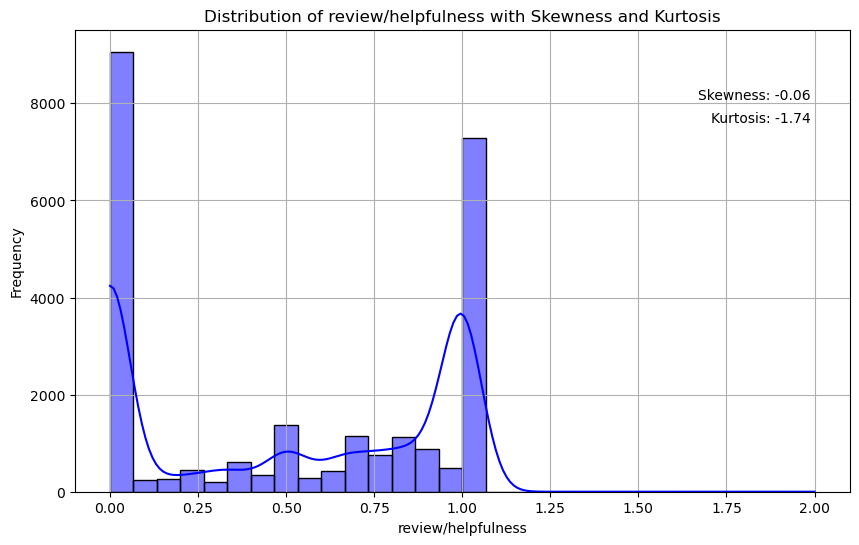

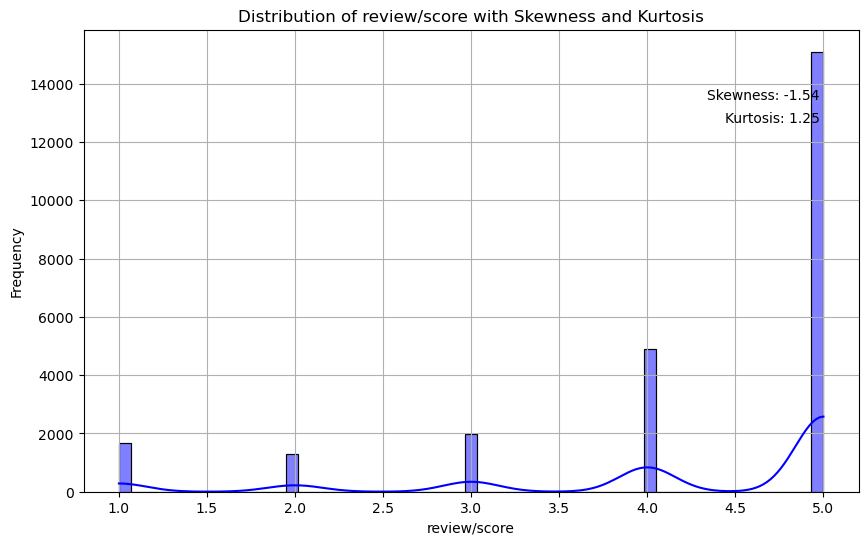

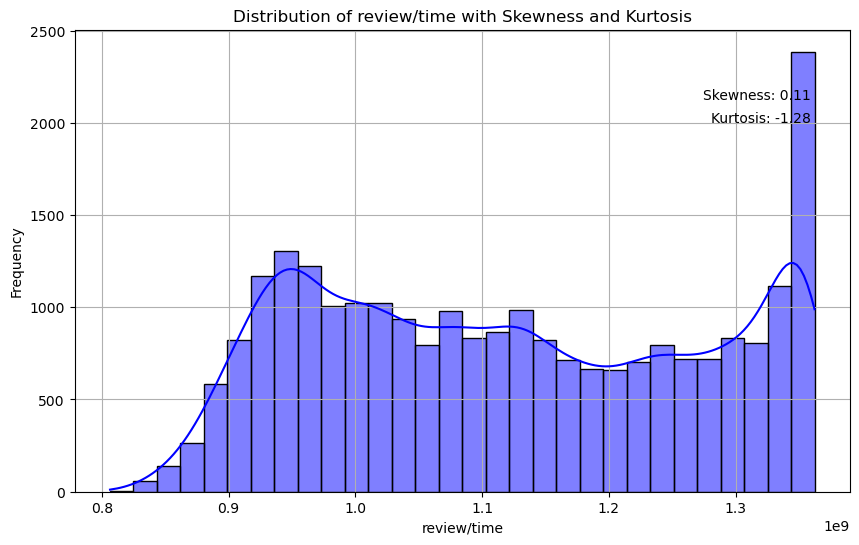

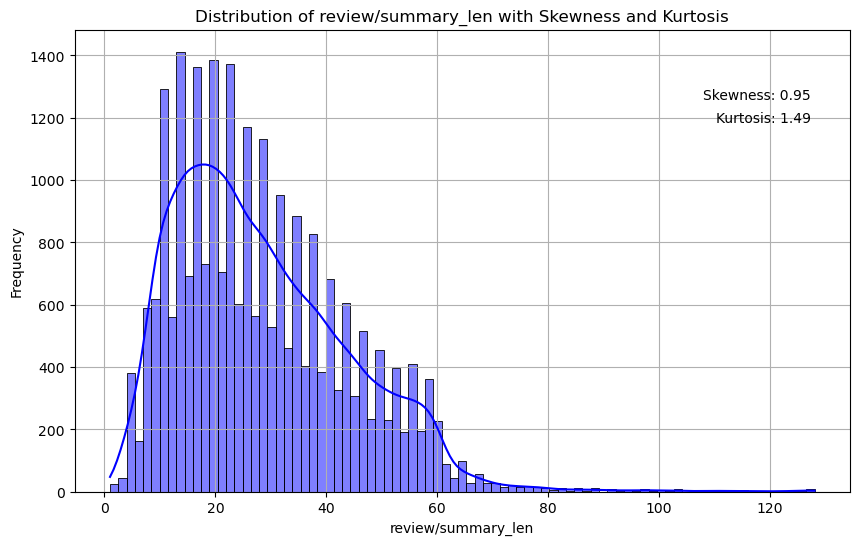

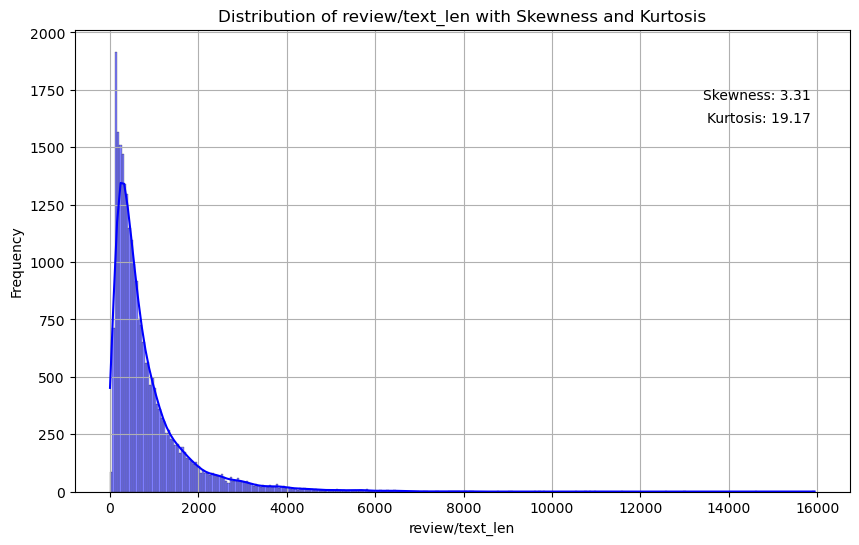

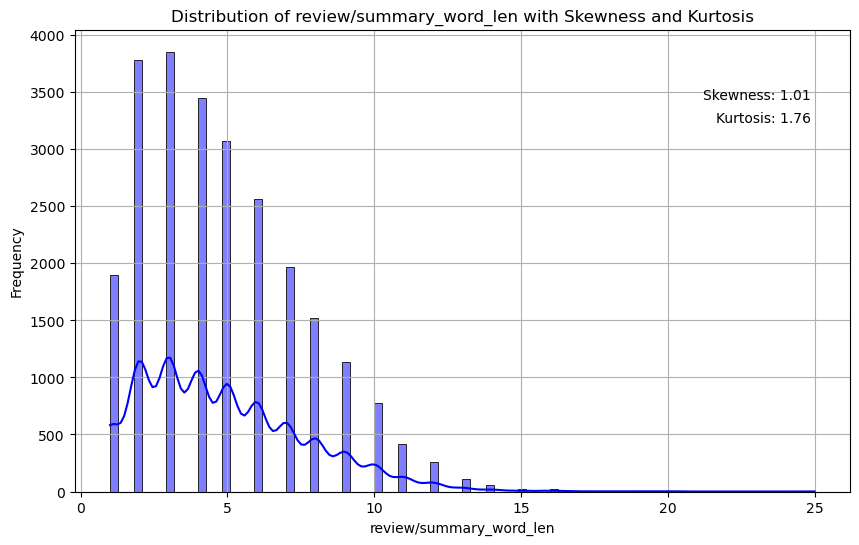

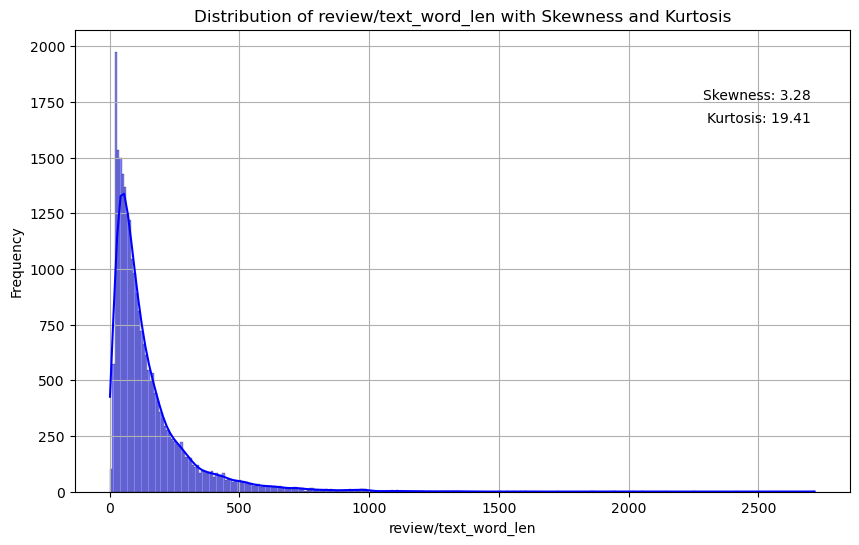

In [44]:
dist_plot(numeric_types)

<AxesSubplot:>

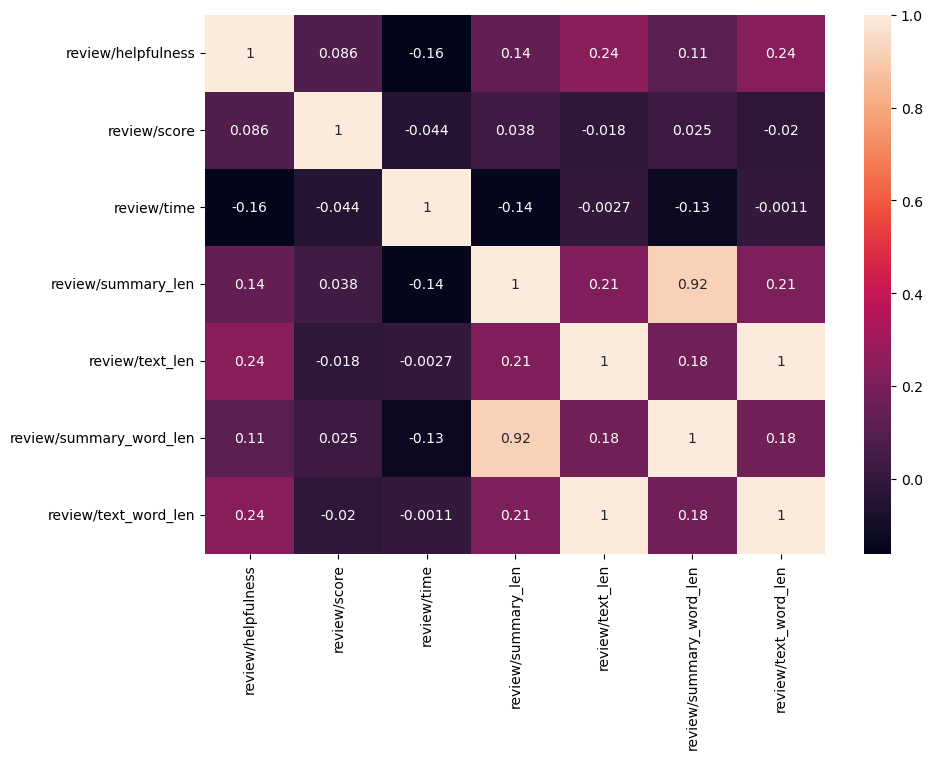

In [45]:
plt.figure(figsize=(10, 7))

sns.heatmap(numeric_types.corr(), annot=True)

# Bert Sentiment Analysis

In [59]:
df['tokenize_text'] = df["review/text"].apply(remove_stop_words)

In [60]:
df["LDA_text"] = df["review/text"].apply(lemmatize_words)
df = df[df['LDA_text'].str.strip() != '']

count_vec = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
dtm = count_vec.fit_transform(df["LDA_text"])


n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', random_state=0)
lda.fit(dtm)

no_top_words = 10
display_topics(lda, count_vec.get_feature_names(), no_top_words)

topic_values = lda.transform(dtm)
df['topic'] = topic_values.argmax(axis=1)


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:
book work author chapter make use information example doe need
Topic 1:
book read like time reading just good really great story
Topic 2:
story character novel life love reader make work book like
Topic 3:
war world american history people foundation state government political america
Topic 4:
god life lewis woman man christianity time human mary christian


/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_99829/2255568576.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['topic'] = topic_values.argmax(axis=1)


<AxesSubplot:xlabel='Topic Distribution', ylabel='Counts'>

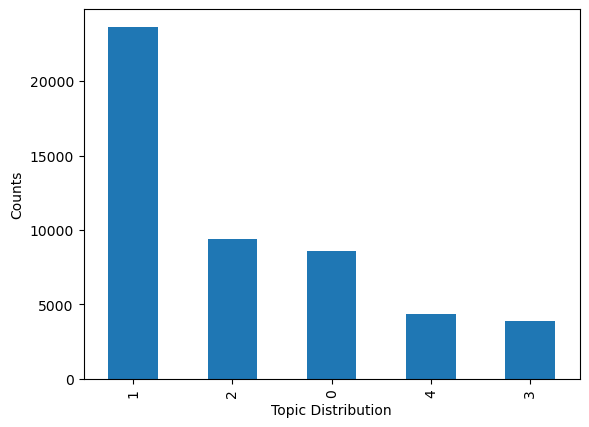

In [61]:
df["topic"].value_counts().plot.bar(xlabel="Topic Distribution", ylabel="Counts")

In [63]:
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

df.loc[:, "shorten_review_text"] = df["tokenize_text"].apply(lambda x: x if len(x) <= 512 else x[:512])

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_99829/1140725112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "shorten_review_text"] = df["tokenize_text"].apply(lambda x: x if len(x) <= 512 else x[:512])


In [ ]:
df["sentiment"] = df["shorten_review_text"].apply(lambda x: sentiment_pipeline(x)[0]["label"])
df["score"] = df["shorten_review_text"].apply(lambda x: sentiment_pipeline(x)[0]["score"])